In [1]:
import json
import os
from pathlib import Path
import matplotlib.pyplot as plt
from torch.nn import MSELoss
from torchvision import transforms
import torch
import onnx
from onnx2torch import convert
import random

from app.utils.dataset import DepthDataset, create_data_loader
from app.utils.env import Env
from models.train_depth_model import SILogLoss, BerHuLoss, evaluate

In [2]:
output_path = Path("output_remote")

files = output_path.glob("*.json")

model_data = {}

for file in files:

    name = file.name.replace(".json", "")

    with open(file) as f:
        data = json.load(f)
        model_data[name] = data

print(model_data)

{'DepthEstimationNet': {'train_loss': [2.359696097898022, 1.5914046481101025, 1.4344775253995552, 1.3974392313614568, 1.340486161155563, 1.3013622730873462, 1.249728500001302, 1.2184823311936028, 1.200309373538266, 1.1783776273492472, 1.1640166270471062, 1.1204343080924244, 1.1098995013094035, 1.104743247346134, 1.1006013569908535, 1.0968803900113566, 1.0937557814567027, 1.0904990027315893, 1.0873215749926857, 1.0797728010555225, 1.0788967577859958, 1.0783335064898494, 1.077695441945983, 1.077462032631829, 1.0769819438911554, 1.0764370254510738, 1.0753348875976212, 1.075373333722025], 'val_loss': [1.7801341400966386, 1.5891575689229491, 1.6339680463480195, 1.5578986632877885, 1.5719612016936773, 1.5791173143084771, 1.5663933117465196, 1.6331880168138047, 1.5605299839606652, 1.5910790311804723, 1.573778509014872, 1.557456626072189, 1.562654394369859, 1.5673664781302887, 1.569860106679649, 1.5736891840378084, 1.573082797128151, 1.5769575575358188, 1.5827666094939634, 1.5837954757440145, 

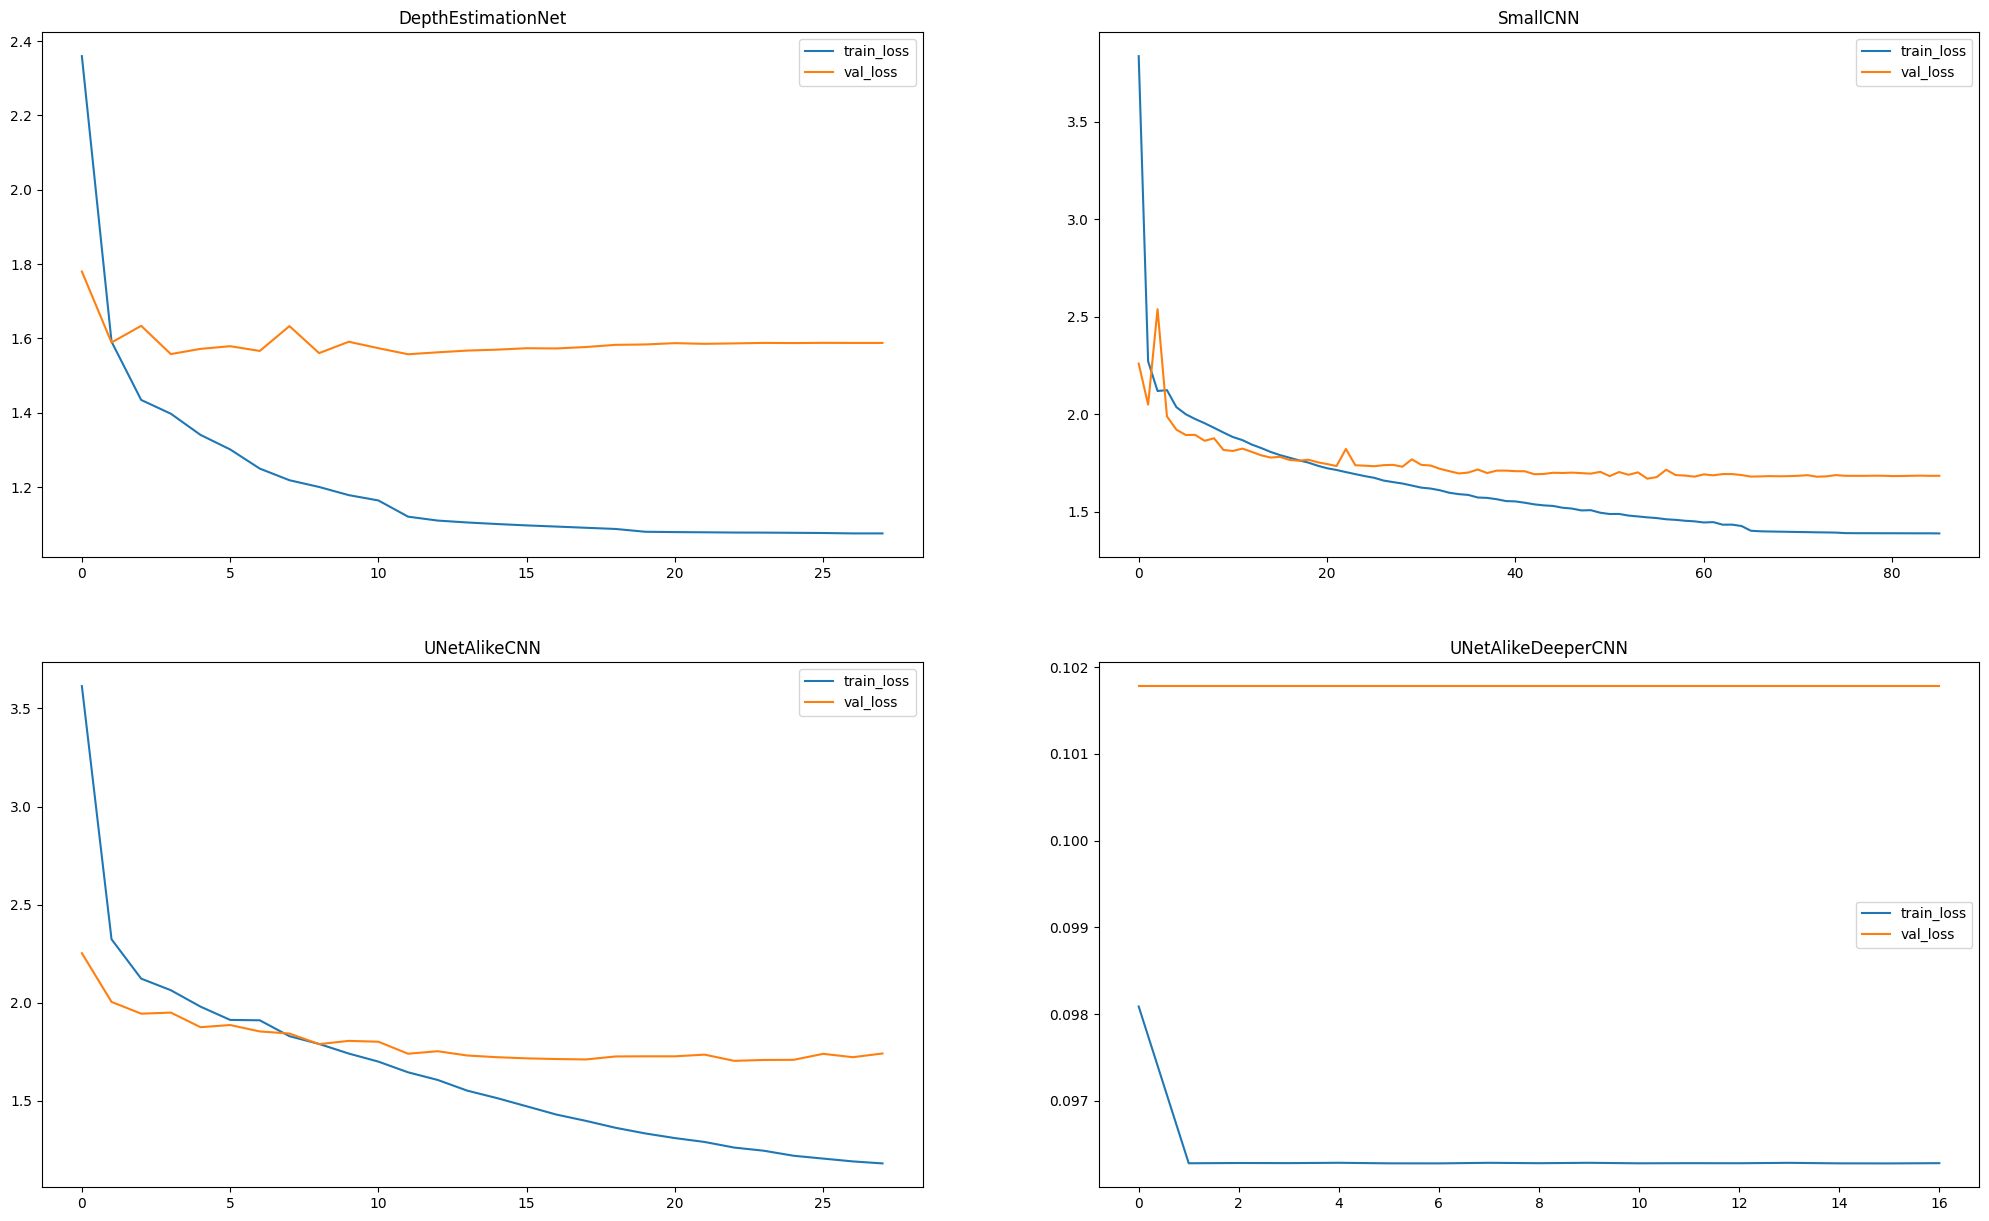

In [3]:
fig = plt.figure(figsize = (25,15))

i = 1

for name, data in model_data.items():
    ax = fig.add_subplot(2,2,i)

    ax.plot(data['train_loss'],label="train_loss")
    ax.plot(data['val_loss'],label="val_loss")
    ax.set_title(name)
    ax.legend()

    i += 1


In [11]:
env = Env()

image_size = 256
transform = transforms.Compose([
    transforms.Resize((256, 848)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

target_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 848)),
    transforms.ToTensor()
])

val_dataset = DepthDataset(
    root_dir=env.dataset_path / "val",
    transform=transform,
    target_transform=target_transform,
)

val_loader = create_data_loader(val_dataset, batch_size=16, shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

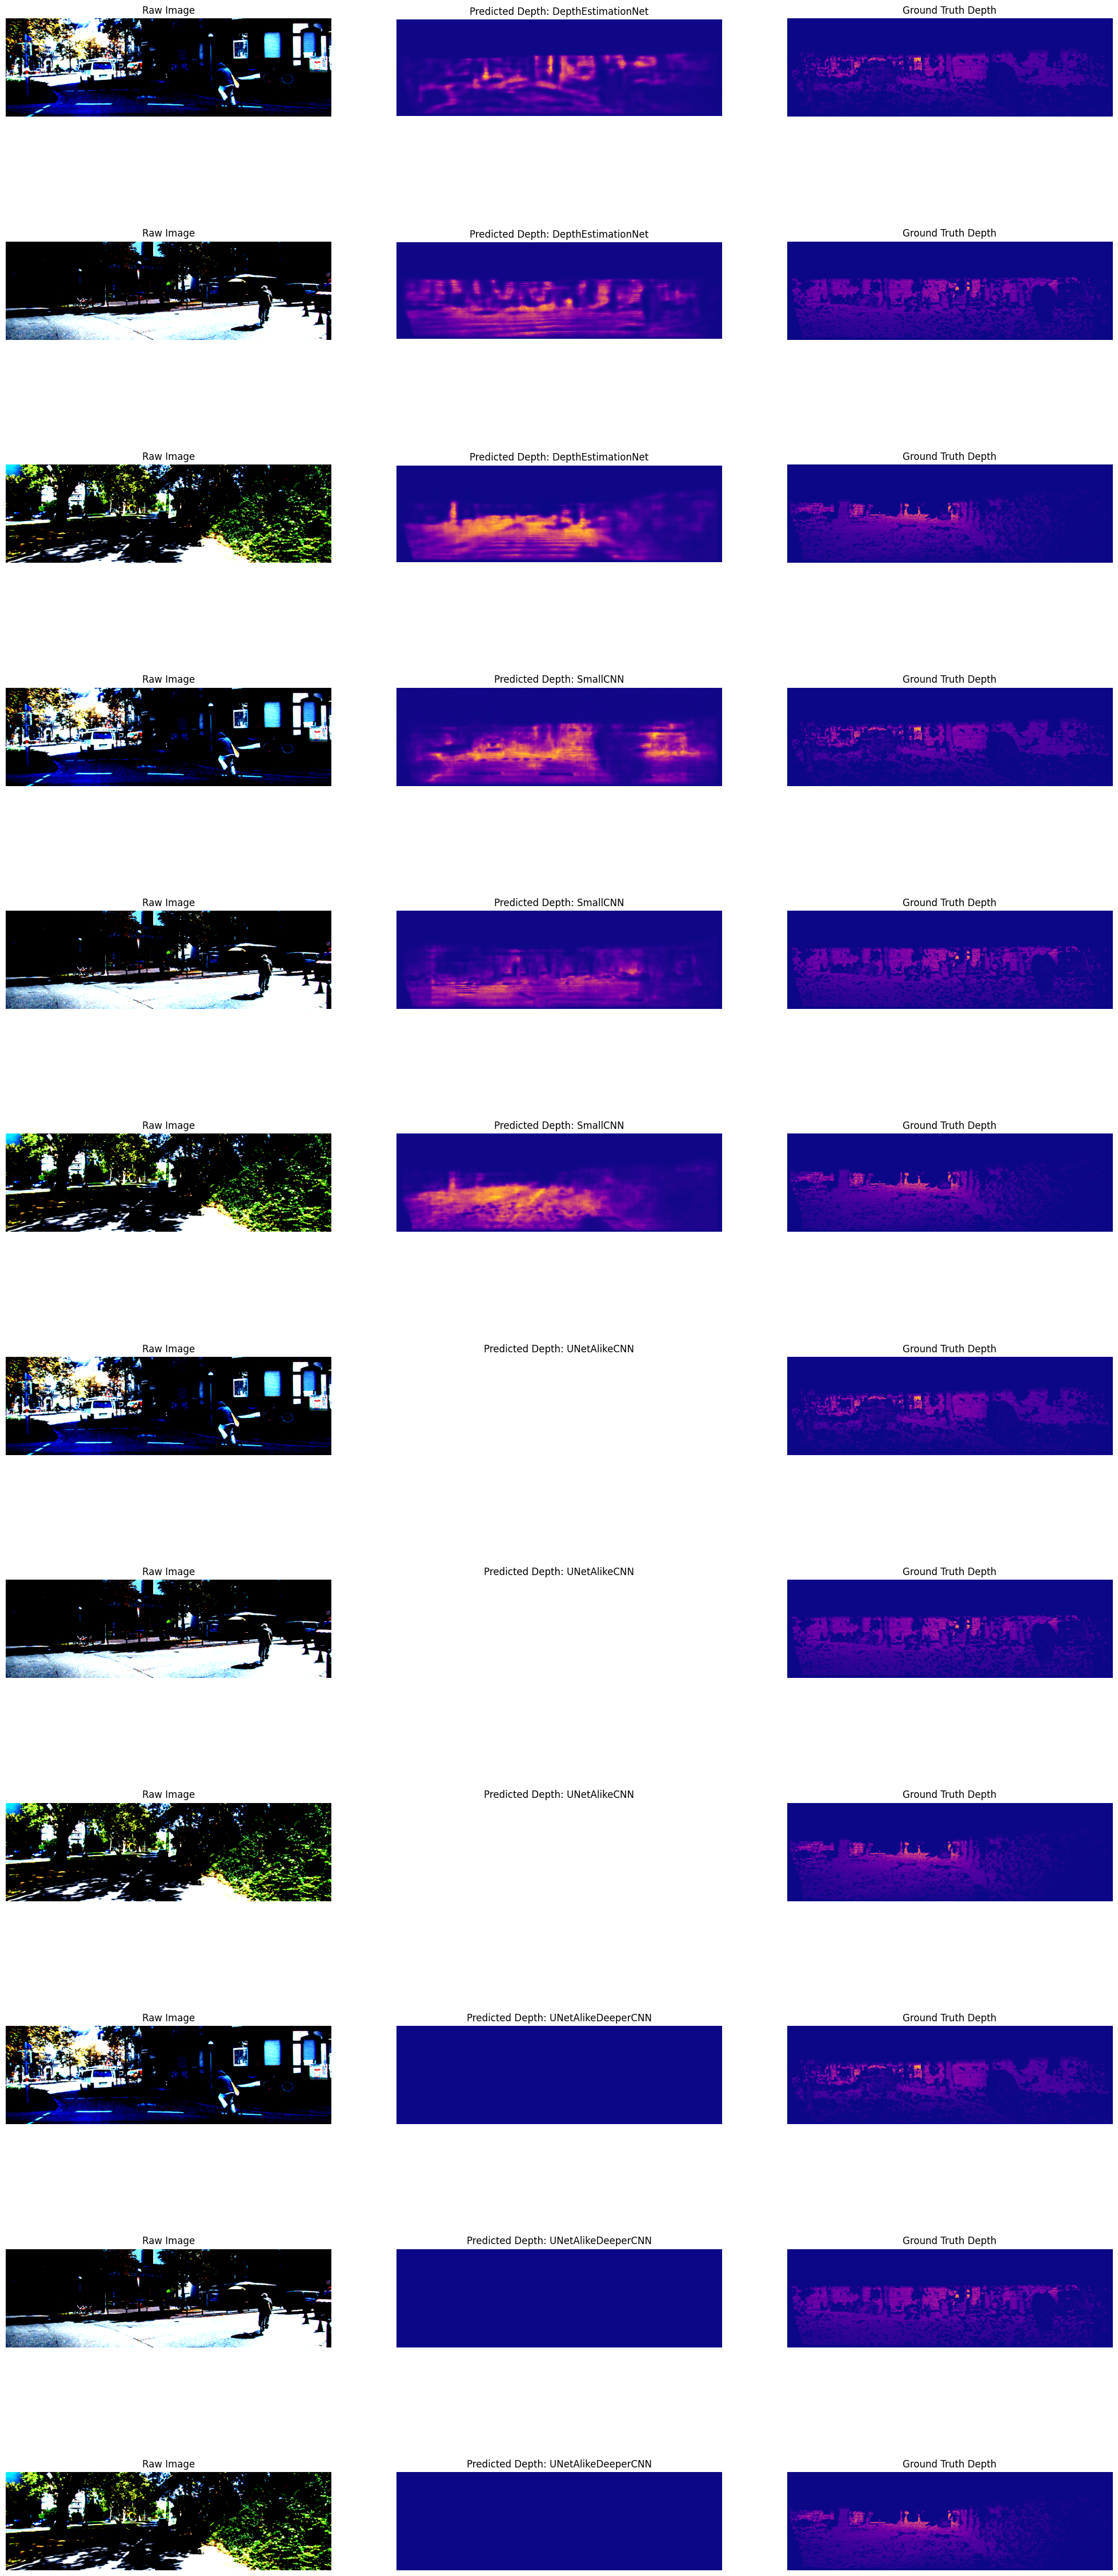

In [16]:
loss_si = SILogLoss()
loss_mse = MSELoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fig = plt.figure(figsize = (25,5 * 3 * 4))

i = 1


for name in model_data.keys():
    random.seed(23^3)
    onnx_model = onnx.load(output_path / f"{name}.onnx")
    model = convert(onnx_model)
    model.to(device)

    # si_loss = evaluate(model, val_loader, loss_si, device)
    # mse_loss = evaluate(model, val_loader, loss_mse, device)

    for _ in range(3):
        ax_raw = fig.add_subplot(12, 3, i)
        i += 1
        ax_pred = fig.add_subplot(12, 3, i)
        i += 1
        ax_target = fig.add_subplot(12, 3, i)
        i += 1

        idx = random.randint(0, len(val_dataset) - 1)
        raw_image, depth_image = val_dataset[idx]
        raw_image = raw_image.unsqueeze(0).to(device)  # [1, 3, H, W]
        with torch.no_grad():
            prediction = model(raw_image)
            prediction = prediction.squeeze().cpu().numpy()


        ax_raw.imshow(raw_image.squeeze().permute(1, 2, 0).cpu(), cmap='plasma')
        ax_raw.set_title("Raw Image")
        ax_raw.axis('off')

        ax_pred.imshow(prediction, cmap='plasma')
        ax_pred.set_title(f"Predicted Depth: {name}")
        ax_pred.axis('off')

        ax_target.imshow(depth_image.permute(1, 2, 0).numpy() * 255, cmap='plasma')
        ax_target.set_title("Ground Truth Depth")
        ax_target.axis('off')
